In [98]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML

In [99]:
import autograd
import autograd.numpy as np


def loss(w, x):
  return -np.log(1.0 / (1 + np.exp(-np.dot(x, w))))


x = np.array([1, -1])
w = np.array([1.0, 0.5])

grad_loss = autograd.grad(loss)
print(loss(w, x))
print(grad_loss(w, x))


0.47407698418010663
[-0.37754067  0.37754067]


In [100]:
import torch

x = torch.tensor([1, -1], dtype=torch.float)
w = torch.tensor([1.0, 0.5], dtype=torch.float, requires_grad=True)

loss = -torch.dot(x, w).sigmoid().log()
loss.backward()
print(loss.item())
print(w.grad)


0.4740769565105438
tensor([-0.3775,  0.3775])


In [101]:
import tensorflow as tf

x = tf.constant([1, -1], dtype=tf.float32, name='x')
w = tf.Variable([1.0, 0.5], dtype=tf.float32, name='w')

with tf.GradientTape() as tape:
  loss = -tf.math.log(tf.math.sigmoid(tf.tensordot(x, w, 1)))

print(loss.numpy())
print(tape.gradient(loss, w))


0.47407696
tf.Tensor([-0.37754062  0.37754062], shape=(2,), dtype=float32)


In [102]:
""" import jax
import jax.numpy as jnp


def loss(w, x):
  return -jnp.log(1.0 / (1 + jnp.exp(-jnp.dot(x, w))))


x = jnp.array([1, -1], dtype=jnp.float32)
w = jnp.array([1.0, 0.5], dtype=jnp.float32)

grad_loss = jax.jit(jax.grad(loss))
print(loss(w, x))
print(grad_loss(w, x))
 """

' import jax\nimport jax.numpy as jnp\n\n\ndef loss(w, x):\n  return -jnp.log(1.0 / (1 + jnp.exp(-jnp.dot(x, w))))\n\n\nx = jnp.array([1, -1], dtype=jnp.float32)\nw = jnp.array([1.0, 0.5], dtype=jnp.float32)\n\ngrad_loss = jax.jit(jax.grad(loss))\nprint(loss(w, x))\nprint(grad_loss(w, x))\n '

In [103]:
import torch


def init_graph(X, dpi=100, figsize=(6, 6)):
  xmin, xmax = X[:, 0].min()-0.5, X[:, 0].max()+0.5
  ymin, ymax = X[:, 1].min()-0.5, X[:, 1].max()+0.5

  fig, ax = plt.subplots(dpi=dpi, figsize=figsize)
  ax.set_xlabel('$x_1$')
  ax.set_ylabel('$x_2$')
  ax.set_xlim(xmin, xmax)
  ax.set_ylim(ymin, ymax)
  return fig, ax


def plot_data(ax, X, Y):
  I = np.where(Y == 0)
  ax.scatter(X[I, 0], X[I, 1], c='tab:blue', marker='_')
  I = np.where(Y == 1)
  ax.scatter(X[I, 0], X[I, 1], c='tab:red', marker='+')


def draw_heatmap(fig, ax, func, step=1, N=1024):
  xmin, xmax = ax.get_xlim()
  ymin, ymax = ax.get_ylim()

  XX, YY = np.meshgrid(np.linspace(xmin, xmax, N), np.linspace(ymin, ymax, N))
  XY = np.vstack([XX.ravel(), YY.ravel()]).T

  X_ = torch.from_numpy(XY).type(dtype)
  Y_ = func(X_).detach().numpy().copy()
  C = Y_.reshape(XX.shape)

  vmin, vmax = C.min(), C.max()
  vmin = ((vmin // step) - 1) * step
  vmax = ((vmax // step) + 1) * step
  width = max(abs(vmin), abs(vmax))

  mesh = ax.pcolormesh(XX, YY, C, norm=matplotlib.colors.Normalize(vmin=-width, vmax=width), cmap='bwr', shading='auto', alpha=0.2)
  cbar = fig.colorbar(mesh, ax=ax)
  cbar.set_label('Output value')

  cont = ax.contour(XX, YY, C, colors='tab:gray', linewidths=0.5, linestyles='dashed', levels=np.arange(vmin, vmax+1, step))
  cont.clabel(fmt='%1.1f')


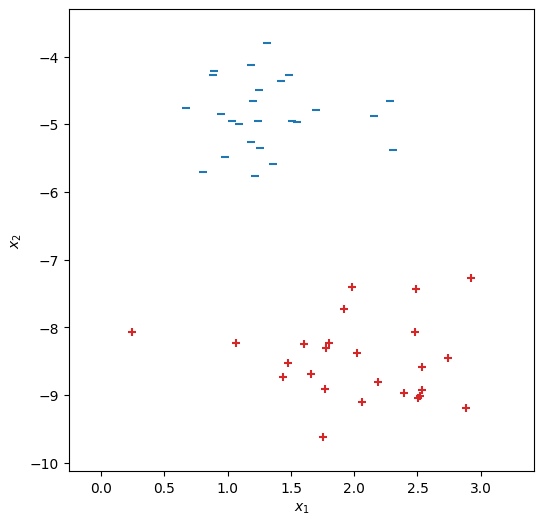

In [104]:
from sklearn.datasets import make_blobs
D = make_blobs(n_samples=50, centers=2, random_state=129, cluster_std=.6)

fig, ax = init_graph(D[0])
plot_data(ax, D[0], D[1])
plt.show()

In [105]:
from torch.utils.data import TensorDataset, DataLoader

dtype = torch.float
X = torch.from_numpy(D[0]).type(dtype)
Y = torch.from_numpy(D[1].reshape(-1, 1)).type(dtype)

In [106]:
X[:4]

tensor([[ 2.4885, -7.4323],
        [ 1.4338, -8.7279],
        [ 2.1874, -8.8029],
        [ 1.1995, -4.6490]])

In [107]:
Y[:4]

tensor([[1.],
        [1.],
        [1.],
        [0.]])

In [108]:
# Create a data loader with batch size of 4.
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Parameters of the single-layer neural network.
w = torch.randn(2, 1, dtype=dtype, requires_grad=True)
b = torch.randn(1, dtype=dtype, requires_grad=True)

H = []
eta = 0.01
for t in range(1000):
  sumloss = 0.
  for x, y in loader:
    y_hat = (x.matmul(w) + b).sigmoid()
    l = y * y_hat + (1 - y) * (1 - y_hat)
    loss = -l.log().sum()
    sumloss += loss.item()

    loss.backward()
    with torch.no_grad():
      w -= eta * w.grad
      b -= eta * b.grad
      w.grad.zero_()
      b.grad.zero_()

  H.append(sumloss)


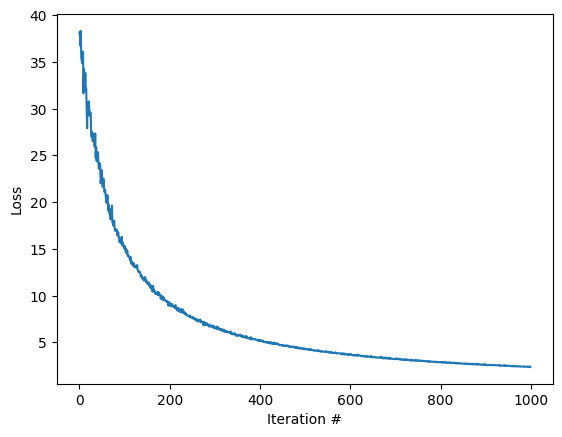

In [109]:
fig, ax = plt.subplots()
ax.plot(H)
ax.set_xlabel('Iteration #')
ax.set_ylabel('Loss')
plt.show()

In [111]:
w, b

(tensor([[ 0.2972],
         [-1.9083]], requires_grad=True),
 tensor([-12.9366], requires_grad=True))

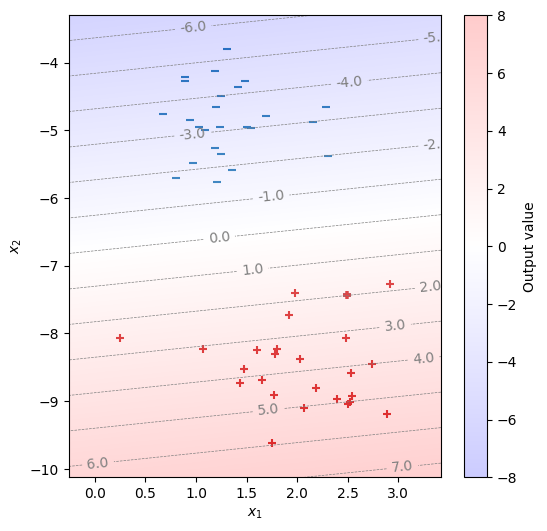

In [110]:
def model(x):
  return x.matmul(w) + b


fig, ax = init_graph(X)
plot_data(ax, X, Y)
draw_heatmap(fig, ax, model)
plt.show()


In [112]:
# Create a data loader with batch size of 4.
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Single-layer NN: 2 -> 1
model = torch.nn.Sequential(
    torch.nn.Linear(2, 1, bias=True),
)
loss_fn = torch.nn.BCEWithLogitsLoss()

eta = 0.1
for t in range(1000):
  for x, y in loader:
    y_hat = model(x)
    loss = loss_fn(y_hat, y)

    model.zero_grad()
    loss.backward()

    with torch.no_grad():
      for param in model.parameters():
        param -= eta * param.grad


In [113]:
model

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)

In [114]:
model.state_dict()

OrderedDict([('0.weight', tensor([[ 0.5821, -2.5734]])),
             ('0.bias', tensor([-17.4550]))])

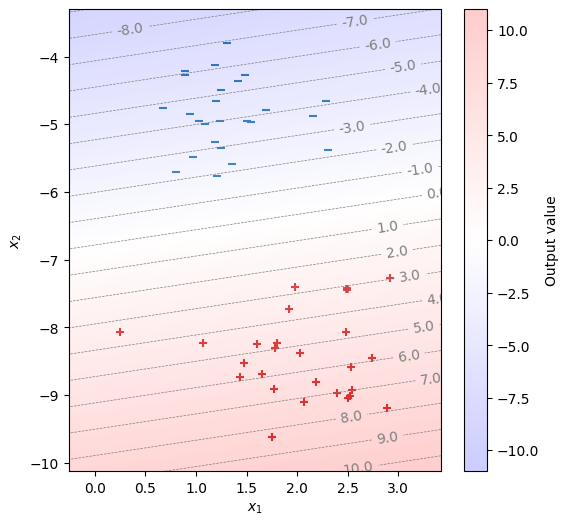

In [115]:
fig, ax = init_graph(X)
plot_data(ax, X, Y)
draw_heatmap(fig, ax, model)
plt.show()

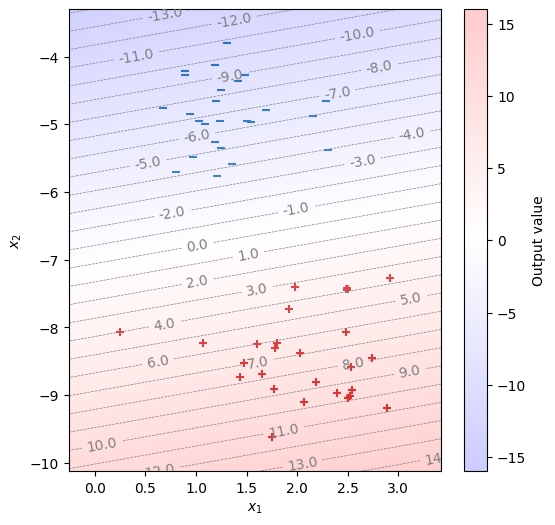

In [116]:
# Create a data loader with batch size of 4.
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Single-layer NN: 2 -> 1
model = torch.nn.Sequential(
    torch.nn.Linear(2, 1, bias=True),
)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

for t in range(1000):
  for x, y in loader:
    y_hat = model(x)
    loss = loss_fn(y_hat, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

fig, ax = init_graph(X)
plot_data(ax, X, Y)
draw_heatmap(fig, ax, model)
plt.show()


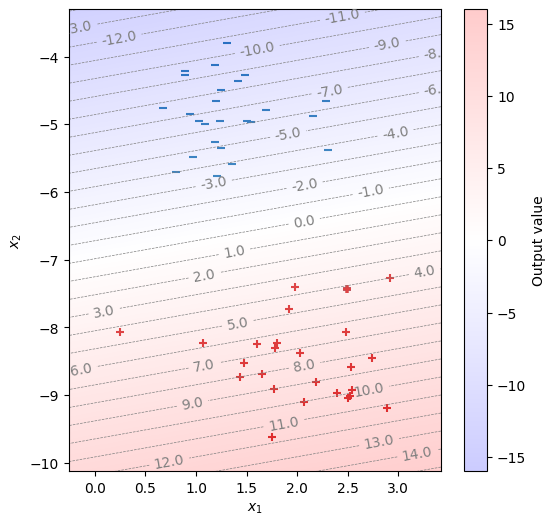

In [117]:
# Create a data loader with batch size of 4.
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Define a neural network as a class.


class SingleLayerNN(torch.nn.Module):
  def __init__(self, d_in, d_out):
    super().__init__()
    self.linear1 = torch.nn.Linear(d_in, d_out, bias=True)

  def forward(self, x):
    return self.linear1(x)


model = SingleLayerNN(2, 1)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

for t in range(1000):
  for x, y in loader:
    y_hat = model(x)
    loss = loss_fn(y_hat, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

fig, ax = init_graph(X)
plot_data(ax, X, Y)
draw_heatmap(fig, ax, model)
plt.show()


In [118]:
model.state_dict()

OrderedDict([('linear1.weight', tensor([[ 1.0051, -3.7585]])),
             ('linear1.bias', tensor([-26.2547]))])

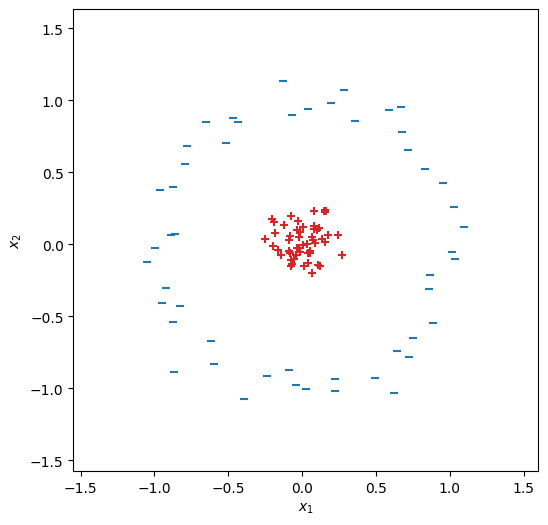

In [119]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_circles

D = make_circles(100, factor=.1, noise=.1, random_state=9)

dtype = torch.float
X = torch.from_numpy(D[0]).type(dtype)
Y = torch.from_numpy(D[1].reshape(-1, 1)).type(dtype)

fig, ax = init_graph(X)
plot_data(ax, X, Y)
plt.show()


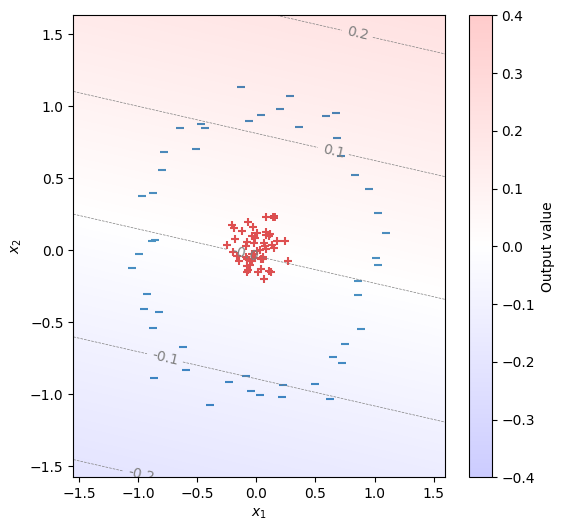

In [120]:
# Create a data loader with batch size of 4.
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Single-layer NN: 2 -> 1
model = torch.nn.Sequential(
    torch.nn.Linear(2, 1, bias=True),
)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

for t in range(1000):
  for x, y in loader:
    y_hat = model(x)
    loss = loss_fn(y_hat, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

fig, ax = init_graph(X)
plot_data(ax, X, Y)
draw_heatmap(fig, ax, model, 0.1)
plt.show()


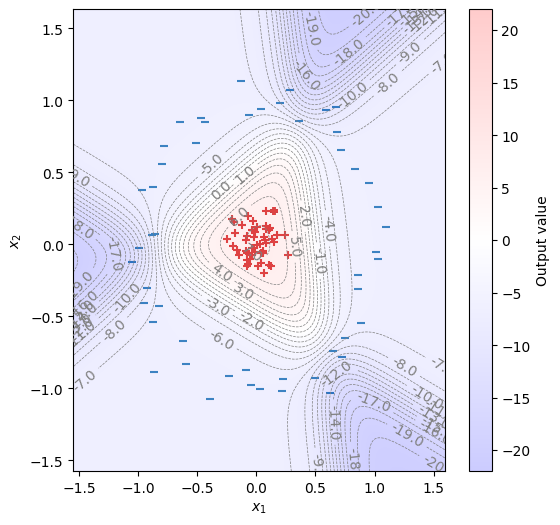

In [121]:
# Create a data loader with batch size of 4.
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Two-layer NN: 2 -> 4 -> 1
model = torch.nn.Sequential(
    torch.nn.Linear(2, 4, bias=True),
    torch.nn.Sigmoid(),
    torch.nn.Linear(4, 1, bias=True),
)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

for t in range(1000):
  for x, y in loader:
    y_hat = model(x)
    loss = loss_fn(y_hat, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

fig, ax = init_graph(X)
plot_data(ax, X, Y)
draw_heatmap(fig, ax, model)
plt.show()


### 確認問題: 自動微分

In [122]:
import numpy as np
import torch


dtype = torch.float

# Variables
W = torch.tensor(np.array([[1, 1], [-1, 1]]), requires_grad=True, dtype=dtype)
b = torch.tensor(np.array([-0.5, 1.5]), requires_grad=True, dtype=dtype)
q = torch.tensor(np.array([1, 1]), requires_grad=True, dtype=dtype)
c = torch.tensor(np.array([-1.5]), requires_grad=True, dtype=dtype)

x = torch.from_numpy(np.zeros(2)).type(dtype)

# Forward
hidden = (x @ W + b).relu()
output = (hidden @ q + c).sigmoid()

print(f"hidden = {hidden}")
print(f"output = {output}")


hidden = tensor([0.0000, 1.5000], grad_fn=<ReluBackward0>)
output = tensor([0.5000], grad_fn=<SigmoidBackward0>)


In [123]:
loss = - torch.log((torch.ones(1) - output))
print(f"loss={loss}")

loss=tensor([0.6931], grad_fn=<NegBackward0>)


In [124]:
loss.backward()
print(f"gradient W: {W.grad}")
print(f"gradient b: {b.grad}")
print(f"gradient q: {q.grad}")
print(f"gradient c: {c.grad}")

gradient W: tensor([[0., 0.],
        [0., 0.]])
gradient b: tensor([0.0000, 0.5000])
gradient q: tensor([0.0000, 0.7500])
gradient c: tensor([0.5000])


In [125]:
import gzip
import sys
import struct
import urllib.request
from pathlib import Path
import numpy as np

file = './mnist.npz'

def read_image(fi):
  magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
  assert magic == 0x00000803
  assert rows == 28
  assert columns == 28
  rawbuffer = fi.read()
  assert len(rawbuffer) == n * rows * columns
  rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n*rows*columns)
  return rawdata.reshape(n, rows, columns).astype(np.float32) / 255.0


def read_label(fi):
  magic, n = struct.unpack(">II", fi.read(8))
  assert magic == 0x00000801
  rawbuffer = fi.read()
  assert len(rawbuffer) == n
  return np.frombuffer(rawbuffer, dtype='>u1', count=n)


def openurl_gzip(url):
  request = urllib.request.Request(
      url,
      headers={
          "Accept-Encoding": "gzip",
          "User-Agent": "Mozilla/5.0 (X11; U; Linux i686) Gecko/20071127 Firefox/2.0.0.11",
      })
  response = urllib.request.urlopen(request)
  return gzip.GzipFile(fileobj=response, mode='rb')


def save_mnist():
  if Path(file).exists():
    return
  np.savez_compressed(
      "data/mnist",
      train_x=read_image(openurl_gzip("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")),
      train_y=read_label(openurl_gzip("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")),
      test_x=read_image(openurl_gzip("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")),
      test_y=read_label(openurl_gzip("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"))
  )


save_mnist()
data = np.load(file)
print("Training data (X):", data["train_x"].shape, data["train_x"].dtype)
print("Training data (Y):", data["train_y"].shape, data["train_y"].dtype)
print("Test data (X):", data["test_x"].shape, data["test_x"].dtype)
print("Test data (Y):", data["test_y"].shape, data["test_y"].dtype)


Training data (X): (60000, 28, 28) float32
Training data (Y): (60000,) uint8
Test data (X): (10000, 28, 28) float32
Test data (Y): (10000,) uint8


In [126]:
num_category = 10
X_train = data["train_x"].reshape((data["train_x"].shape[0], -1))
Y_train = np.zeros((data["train_y"].shape[0], num_category))
Y_train[np.arange(len(data["train_y"])), data["train_y"]] = 1.0
print(X_train.shape)
print(Y_train.shape)

(60000, 784)
(60000, 10)


In [127]:
X_test = data["test_x"].reshape((data["test_x"].shape[0], -1))
Y_test = np.zeros((data["test_y"].shape[0], num_category))
Y_test[np.arange(len(data["test_y"])), data["test_y"]] = 1.0
print(X_test.shape)
print(Y_test.shape)

(10000, 784)
(10000, 10)


In [128]:
from torch.utils.data import TensorDataset


train_data = TensorDataset(
    torch.from_numpy(X_train).type(dtype),
    torch.from_numpy(Y_train).type(dtype)
)
test_data = TensorDataset(
    torch.from_numpy(X_test).type(dtype),
    torch.from_numpy(Y_test).type(dtype)
)


In [129]:
from torch.utils.data import DataLoader


model = torch.nn.Sequential(
    torch.nn.Linear(28 * 28, 10),
    torch.nn.Softmax(dim=1)
)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loader = DataLoader(train_data, batch_size=32, shuffle=True)

history = []
for t in range(30):
  sum_loss = 0
  for x, y in loader:
    loss = loss_function(y, model(x))
    sum_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  history.append(sum_loss)


<Axes: title={'center': 'loss per epoch'}>

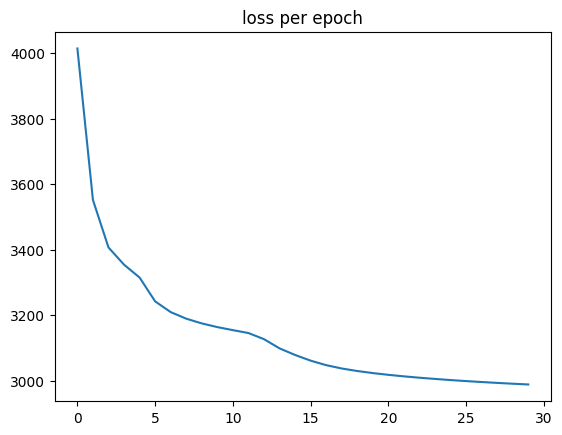

In [130]:
import pandas as pd


pd.Series(history).plot.line(title="loss per epoch")

In [131]:
from sklearn.metrics import classification_report


y_hat = None
with torch.inference_mode():
  y_proba = model(torch.from_numpy(X_test).type(dtype)).numpy()
  y_hat = np.argmax(y_proba, axis=1)
  y_max_proba = np.amax(y_proba, axis=1)

print(classification_report(data["test_y"], y_hat))


              precision    recall  f1-score   support

           0       0.92      0.98      0.95       980
           1       0.96      0.97      0.96      1135
           2       0.92      0.87      0.89      1032
           3       0.91      0.89      0.90      1010
           4       0.89      0.93      0.91       982
           5       0.89      0.80      0.84       892
           6       0.92      0.94      0.93       958
           7       0.91      0.91      0.91      1028
           8       0.85      0.89      0.87       974
           9       0.90      0.88      0.89      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [132]:
import matplotlib.pyplot as plt


def mnist_plot(x, y, y_hat):
  fig = plt.figure(dpi=100)
  ax = fig.add_subplot(1, 1, 1)
  ax.set_title(f"Gold label: {y}, Predicted: {y_hat}")
  im = ax.imshow(x)
  fig.colorbar(im)
  plt.show()


In [133]:
predictions_df = pd.DataFrame({
    "y": data["test_y"],
    "y_hat": y_hat,
    "y_proba": y_max_proba
})

correct_df = predictions_df[(predictions_df["y"] == predictions_df["y_hat"])]
correct_df.nlargest(3, "y_proba")


,y,y_hat,y_proba
1341,2,2,1.0
3668,2,2,1.0
5297,7,7,1.0


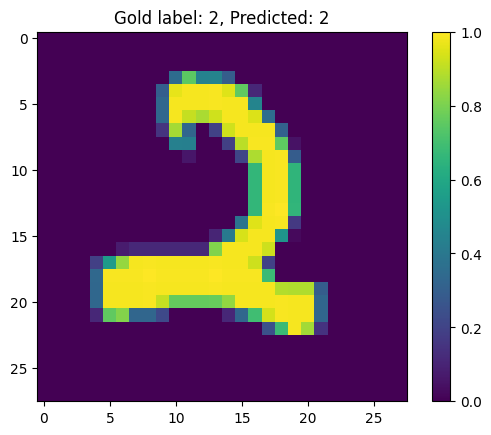

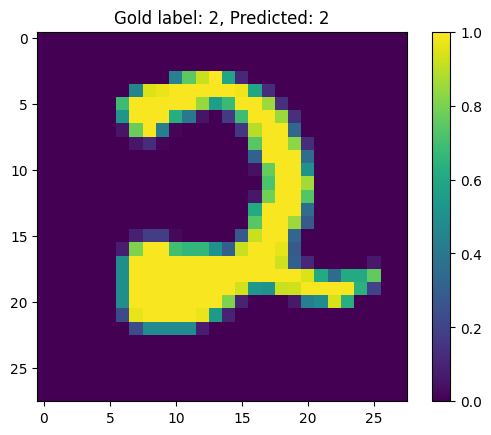

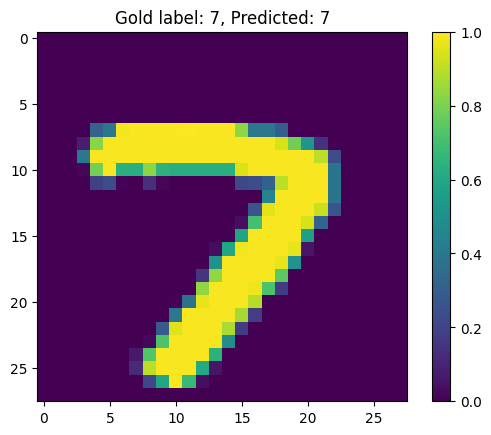

In [134]:
for i in correct_df.nlargest(3, "y_proba").index:
  mnist_plot(data["test_x"][i].reshape((28, 28)), predictions_df["y"][i], predictions_df["y_hat"][i])


In [135]:
different_df = predictions_df[(predictions_df["y"] != predictions_df["y_hat"])]
different_df.nsmallest(3, "y_proba")

,y,y_hat,y_proba
7195,5,6,0.169767
4248,2,4,0.230785
1782,8,2,0.251805


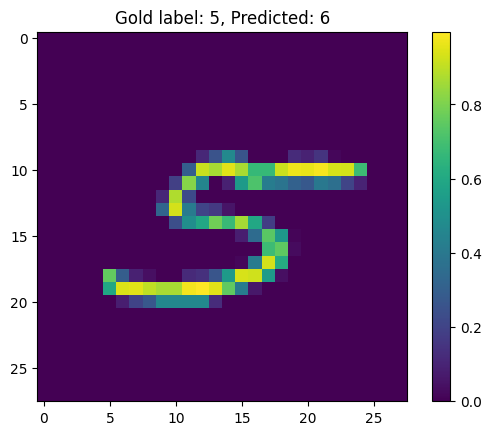

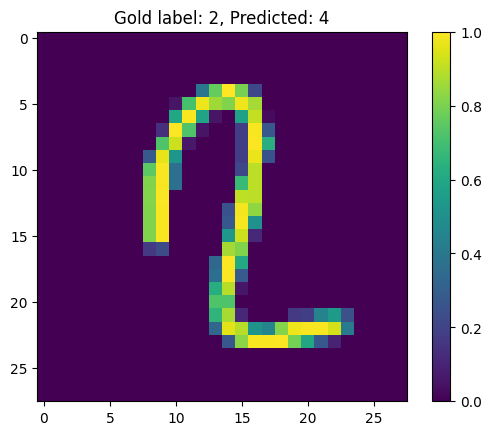

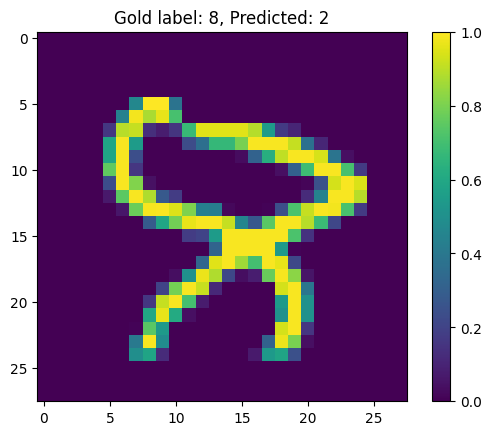

In [136]:
for i in different_df.nsmallest(3, "y_proba").index:
  mnist_plot(data["test_x"][i].reshape((28, 28)), predictions_df["y"][i], predictions_df["y_hat"][i])


In [137]:
model_mlp = torch.nn.Sequential(
    torch.nn.Linear(28 * 28, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 10),
    torch.nn.Softmax(dim=1)
)


optimizer_mlp = torch.optim.SGD(model_mlp.parameters(), lr=0.01)

history = []
for t in range(30):
  sum_loss = 0
  for x, y in loader:
    loss = loss_function(y, model_mlp(x))
    sum_loss += loss.item()
    optimizer_mlp.zero_grad()
    loss.backward()
    optimizer_mlp.step()

  history.append(sum_loss)


<Axes: title={'center': 'loss per epoch'}>

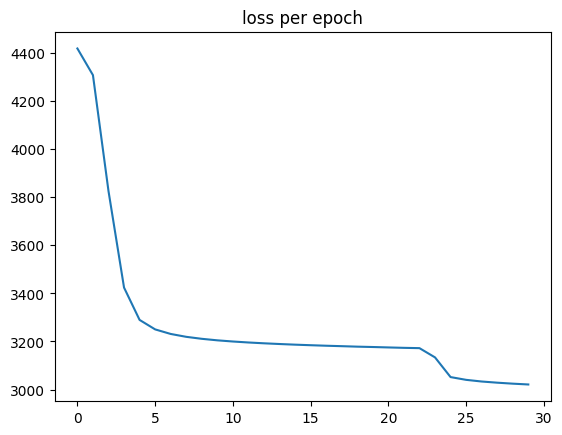

In [138]:
pd.Series(history).plot.line(title="loss per epoch")


In [139]:
from sklearn.metrics import classification_report


y_hat = None
with torch.inference_mode():
  y_proba = model_mlp(torch.from_numpy(X_test).type(dtype)).numpy()
  y_hat = np.argmax(y_proba, axis=1)
  y_max_proba = np.amax(y_proba, axis=1)

print(classification_report(data["test_y"], y_hat))


              precision    recall  f1-score   support

           0       0.89      0.99      0.94       980
           1       0.98      0.98      0.98      1135
           2       0.92      0.93      0.93      1032
           3       0.71      0.94      0.81      1010
           4       0.89      0.94      0.92       982
           5       0.00      0.00      0.00       892
           6       0.90      0.96      0.93       958
           7       0.91      0.94      0.92      1028
           8       0.68      0.88      0.77       974
           9       0.91      0.92      0.92      1009

    accuracy                           0.86     10000
   macro avg       0.78      0.85      0.81     10000
weighted avg       0.79      0.86      0.82     10000



/home/buntin/jupyterlab/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/buntin/jupyterlab/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/buntin/jupyterlab/lib64/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
